In [30]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/AST/"

Mounted at /content/gdrive


In [21]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 11.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=3f924ad054fa1cc1b2c330206a2bbc0ce84d9b18d5e01f7236fa22a3c0abee75
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [24]:
import pandas as pd
import yfinance as yf
from datetime import datetime as dt

In [5]:
!pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-40s0tefh
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-40s0tefh
     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75764 sha256=c3572109cac9453390000a19400893ebb749e83ea3bb0d83a257ee90c5546564
  Stored in directory: /tmp/pip-ephem-wheel-cache-lii576hv/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
  Created wheel for empyrical: filename=empyrical-0.5.5-cp37-none-any.whl size=39764 sha256=6710b763b1c6299f58de8d54c773433307367b8a31cb2ebd44ae51311ca7dc84
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [6]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [83]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    # df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [84]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [85]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv(root_dir + 'results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## DJIA

In [117]:
location = root_dir + "data/^DJI.csv"
dji = pd.read_csv(location)
test_dji=dji[(dji['Date']>='2016-07-30') & (dji['Date']<='2021-04-30')]
test_dji = test_dji.reset_index(drop=True)

In [118]:
test_dji.shape

(1196, 7)

In [119]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-01,184.350006,184.520004,183.380005,183.869995,165.475449,3295900
1,2016-08-02,183.699997,183.880005,182.309998,182.970001,164.665451,5139500
2,2016-08-03,182.850006,183.429993,182.710007,183.360001,165.016449,3008200
3,2016-08-04,183.500000,183.889999,183.149994,183.449997,165.097458,2368900
4,2016-08-05,184.399994,185.279999,183.429993,185.259995,166.726425,4187700


In [120]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [121]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [122]:
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']

In [123]:
df = pd.DataFrame()
for tic in dow_30_ticker:
    data_df = yf.download(tic, start="2010-01-01", end="2021-05-23")
    data_df['tic'] = tic
    df=df.append(data_df)

df=df.reset_index()
print(df.columns)
df.rename(columns={"Date": "datadate", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close": "adjcp", "Volume": "volume", "tic": "tic"}, inplace = True)
df.datadate = df.datadate.dt.strftime("%Y%m%d").astype(int)
print(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [124]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20160501)&(df.datadate <= 20210207)].datadate.unique()

In [125]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [126]:
ensemble_account_value = get_account_value('ensemble')

0.536405313494693


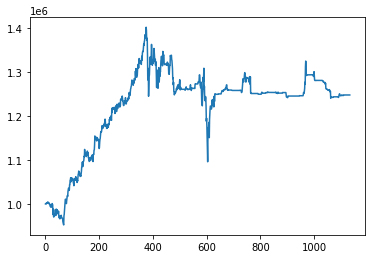

In [127]:
ensemble_account_value.account_value.plot()

In [128]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  0.536405313494693


In [129]:
ensemble_account_value['Date'] = test_dji['Date']

In [130]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20160801,NaN,2016-08-01
1,9.996342e+05,20160802,-0.000366,2016-08-02
2,9.998984e+05,20160803,0.000264,2016-08-03
3,9.997776e+05,20160804,-0.000121,2016-08-04
4,1.002454e+06,20160805,0.002677,2016-08-05


In [131]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [135]:
# ensemble_account_value.to_csv(root_dir + 'results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-08-01
End date,2020-12-07
Total months,52
,Backtest
Annual return,5.197%
Cumulative returns,24.676%
Annual volatility,10.293%
Sharpe ratio,0.54
Calmar ratio,0.24
Stability,0.40
Max drawdown,-21.814%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.81,2018-01-26,2018-12-24,NaT,NaN
1,5.15,2016-08-15,2016-11-04,2016-11-14,66
2,2.48,2017-04-25,2017-05-17,2017-05-24,22
3,2.46,2017-03-01,2017-04-13,2017-04-24,39
4,1.77,2017-06-19,2017-06-27,2017-07-14,20


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


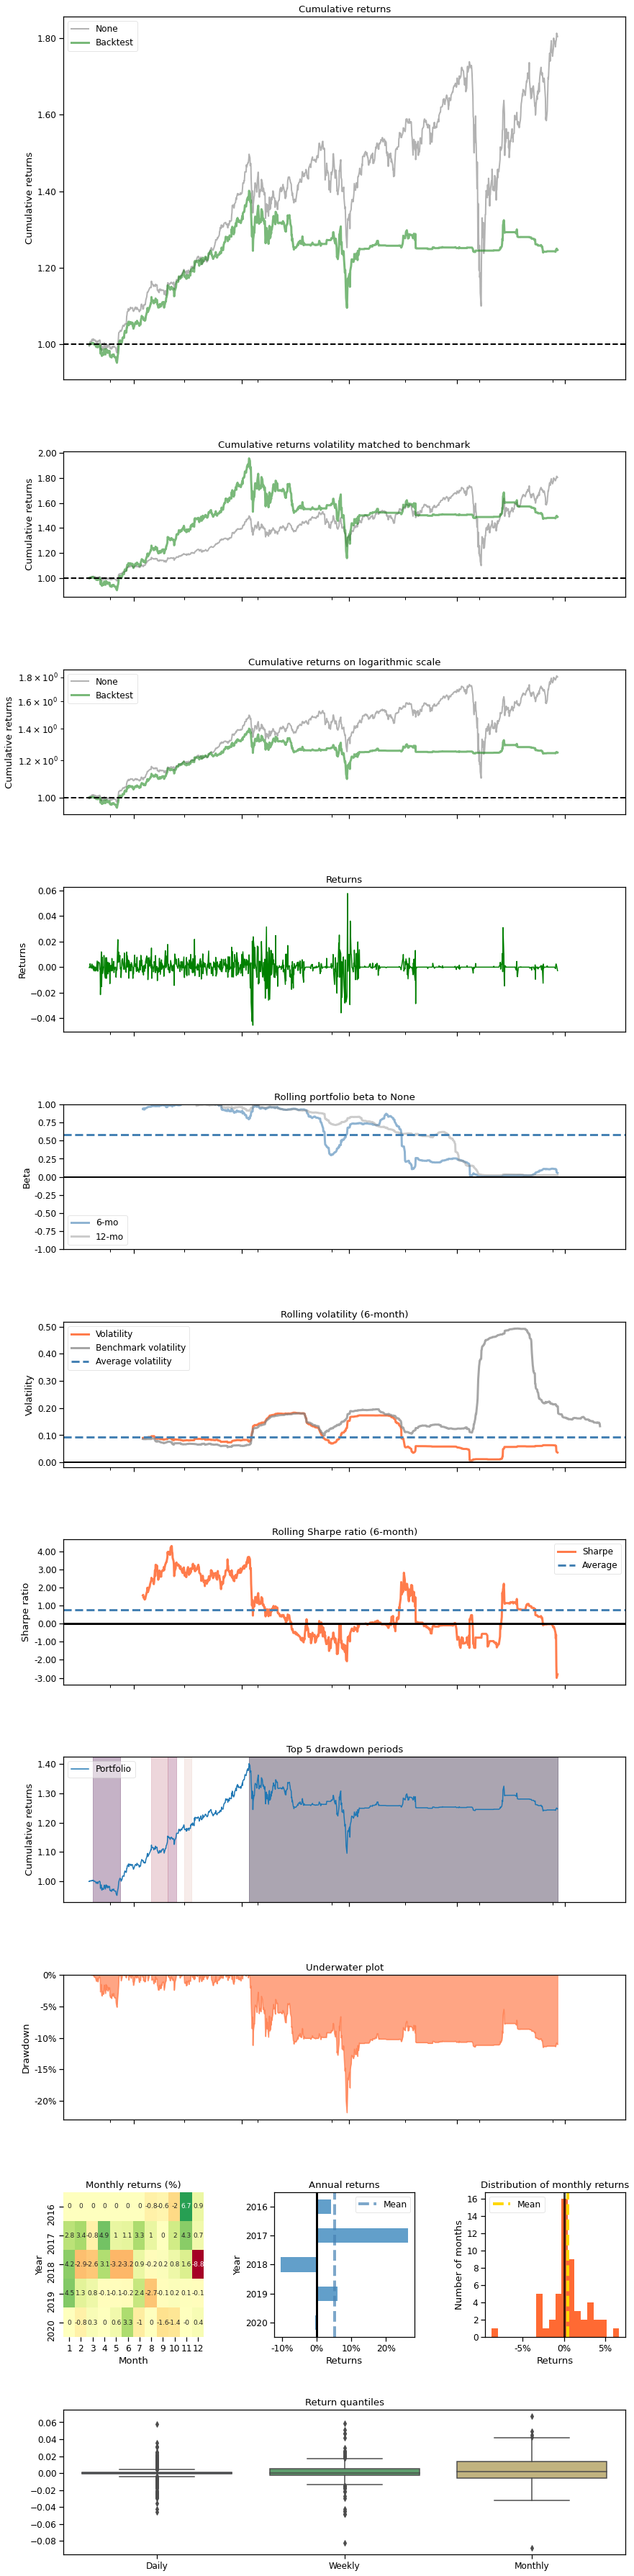

In [133]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)